# Utilizando Ensembles no dataset da competição Titanic do Kaggle

##Pré-processamento

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
#lendo os dados de treinamento e exibindo os tipos das características
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/datasets/train.csv")
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [63]:
#isolando o target, a coluna que devemos fazer a predição
y = data['Survived']
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [64]:
#removendo o target do dataset de treinamento
X = data.drop('Survived', axis=1)
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [65]:
#criação de classe que removerá as características indesejadas para o modeloo
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosDesejados(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasIndesejadas_ = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    return self
  def transform(self, X, y=None):
    return X.drop(self.colunasIndesejadas_, axis=1)

atributosDesejados = AtributosDesejados()
Xdrop = atributosDesejados.fit_transform(X)
Xdrop.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [66]:
#criação de classe que retornará dataset com as colunas numéricas
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosNumericos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasNumericas = X.select_dtypes(include='number').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasNumericas]

atributosNumericos = AtributosNumericos()
Xnum = atributosNumericos.fit_transform(Xdrop)
Xnum.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [67]:
#criando pipeline para pré-processamento das características numéricas
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipenum = Pipeline([
    ('atributos_numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

XnumLimpo = pipenum.fit_transform(Xdrop)
XnumLimpo

array([[ 0.82737724, -0.56573646,  0.43279337, -0.47367361, -0.50244517],
       [-1.56610693,  0.66386103,  0.43279337, -0.47367361,  0.78684529],
       [ 0.82737724, -0.25833709, -0.4745452 , -0.47367361, -0.48885426],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337,  2.00893337, -0.17626324],
       [-1.56610693, -0.25833709, -0.4745452 , -0.47367361, -0.04438104],
       [ 0.82737724,  0.20276197, -0.4745452 , -0.47367361, -0.49237783]])

In [68]:
#criação de classe que retornará dataset com as colunas categóricas
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosCategoricos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasCategoricas = X.select_dtypes(include='object').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasCategoricas]

atributosCategoricos = AtributosCategoricos()
Xcat = atributosCategoricos.fit_transform(Xdrop)
Xcat.columns

Index(['Sex', 'Embarked'], dtype='object')

In [69]:
#criando pipeline para pré-processamento das características categóricas
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

pipecat = Pipeline([
    ('atributos_categoricos', AtributosCategoricos()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

XcatLimpo = pipecat.fit_transform(Xdrop)
XcatLimpo.toarray()

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

In [70]:
#criando pipeline que concatena as características numéricas e categóorias tratadas
from sklearn.pipeline import FeatureUnion

unecaracteristicas = FeatureUnion([
    ('pipenum', pipenum),
    ('pipecat', pipecat)
])

Xtratado = unecaracteristicas.fit_transform(Xdrop)
Xtratado.toarray()

array([[ 0.82737724, -0.56573646,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693,  0.66386103,  0.43279337, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693, -0.25833709, -0.4745452 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724,  0.20276197, -0.4745452 , ...,  0.        ,
         1.        ,  0.        ]])

In [71]:
#cria o pipeline de pré-processamento
from sklearn.pipeline import Pipeline

preproc = Pipeline([
    ('atributos_desejados', AtributosDesejados()),
    ('unecaracteristicas', unecaracteristicas)
])

Xtratado = preproc.fit_transform(X)
Xtratado.toarray()

array([[ 0.82737724, -0.56573646,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693,  0.66386103,  0.43279337, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693, -0.25833709, -0.4745452 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724,  0.20276197, -0.4745452 , ...,  0.        ,
         1.        ,  0.        ]])

# Ensembles

In [72]:
#carregando os dados de treinamento e teste
import pandas as pd
test = pd.read_csv('/content/drive/MyDrive/datasets/test.csv')

## RandomForest

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pipetotal = Pipeline([
    ('preproc', preproc),
    ('rfc', RandomForestClassifier())
])

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.9797979797979798

In [74]:
#avaliação do modelo com validação cruzada
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.31201053, 0.2965734 , 0.29866648, 0.3118751 , 0.29786706]),
  'score_time': array([0.017519  , 0.01516223, 0.0156045 , 0.01555896, 0.01569629]),
  'test_score': array([0.7877095 , 0.80898876, 0.83146067, 0.7752809 , 0.84831461])},
 0.8103508882053857)

In [75]:
#realiza a predição e cria arquivo para submissão ao kaggle
pipetotal.fit(X, y)
ypred = pipetotal.predict(test)

submission = pd.read_csv('/content/drive/MyDrive/datasets/gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('rfc_submission.csv', index=False)

Print da submissão do arquivo ao Kaggle

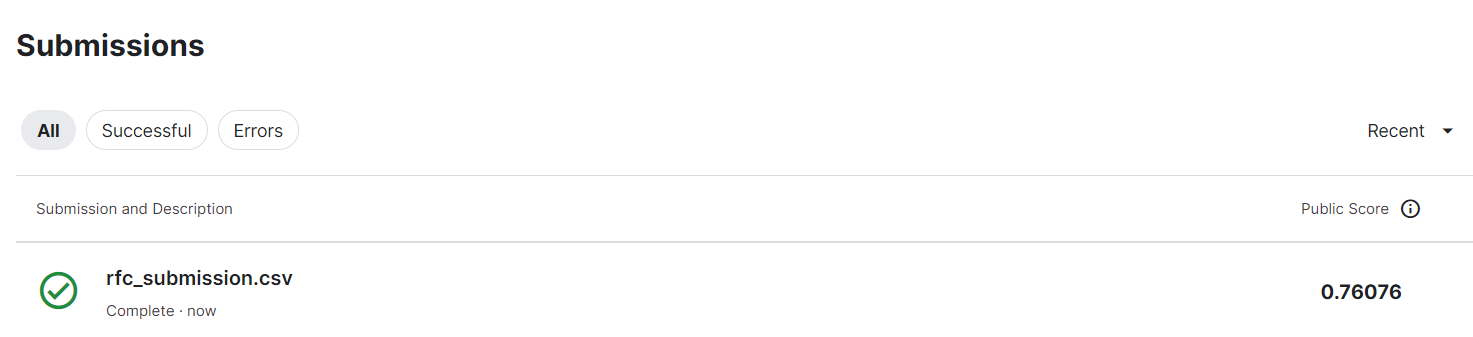

## BaggingClassifier

In [76]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

pipetotal = Pipeline([
    ('preproc', preproc),
    ('bgc', BaggingClassifier(DecisionTreeClassifier(splitter='random'),
                              n_estimators=500, max_features=0.8, random_state=42))
])

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.978675645342312

In [77]:
#avaliação do modelo com validação cruzada
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([3.1002903 , 5.45403481, 2.9548111 , 2.04299569, 2.07207298]),
  'score_time': array([0.56249404, 0.34372449, 0.2446785 , 0.24023676, 0.25785661]),
  'test_score': array([0.81005587, 0.82022472, 0.83707865, 0.78089888, 0.84831461])},
 0.8193145439708743)

In [78]:
#realiza a predição e cria arquivo para submissão ao kaggle
pipetotal.fit(X, y)
ypred = pipetotal.predict(test)

submission = pd.read_csv('/content/drive/MyDrive/datasets/gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('bagging_submission.csv', index=False)

Print da submissão do arquivo ao Kaggle

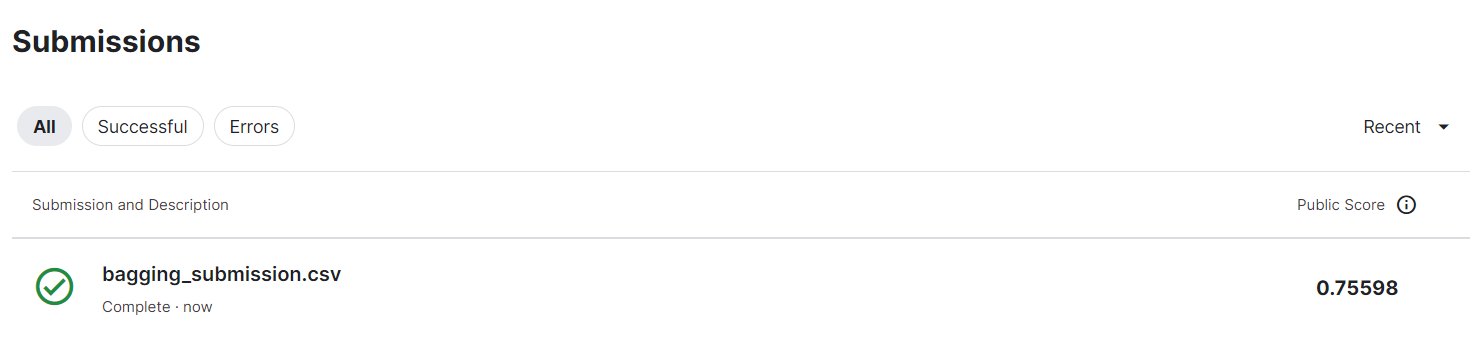

## AdaBoostClassifier

In [79]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

pipetotal = Pipeline([
    ('preproc', preproc),
    ('abc', AdaBoostClassifier(DecisionTreeClassifier(max_depth=25, splitter='random'),
                            learning_rate=0.15, random_state=42))
])

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.9797979797979798

In [80]:
#avaliação do modelo com validação cruzada
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.28578925, 0.27642488, 0.27368379, 0.27630997, 0.30948925]),
  'score_time': array([0.02752161, 0.03288794, 0.02908778, 0.02682948, 0.0298202 ]),
  'test_score': array([0.77653631, 0.76404494, 0.8258427 , 0.7752809 , 0.8258427 ])},
 0.7935095097608437)

In [81]:
#realiza a predição e cria arquivo para submissão ao kaggle
pipetotal.fit(X, y)
ypred = pipetotal.predict(test)

submission = pd.read_csv('/content/drive/MyDrive/datasets/gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('adaboost_submission.csv', index=False)

Print da submissão do arquivo ao Kaggle

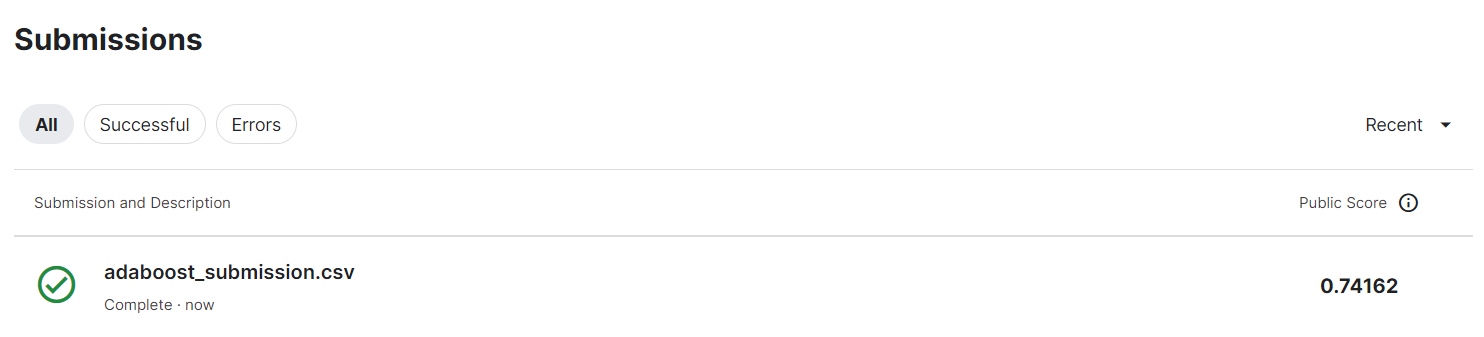

## Voting Classifiers

In [82]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

In [83]:
pipetotal = Pipeline([
    ('preproc', preproc),
    ('voting', VotingClassifier([
      ('knn', KNeighborsClassifier()),
      ('svc', svm.SVC()),
      ('dtc', DecisionTreeClassifier()),
  ]))
])

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.8855218855218855

In [84]:
#avaliação do modelo com validação cruzada
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.05803204, 0.06307817, 0.05087948, 0.05988169, 0.05677915]),
  'score_time': array([0.0836401 , 0.05026197, 0.04107022, 0.05892229, 0.05530477]),
  'test_score': array([0.80446927, 0.79775281, 0.83707865, 0.80898876, 0.84831461])},
 0.8193208210407381)

In [85]:
#realiza a predição e cria arquivo para submissão ao kaggle
pipetotal.fit(X, y)
ypred = pipetotal.predict(test)

submission = pd.read_csv('/content/drive/MyDrive/datasets/gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('voting_submission.csv', index=False)

Print da submissão do arquivo ao Kaggle

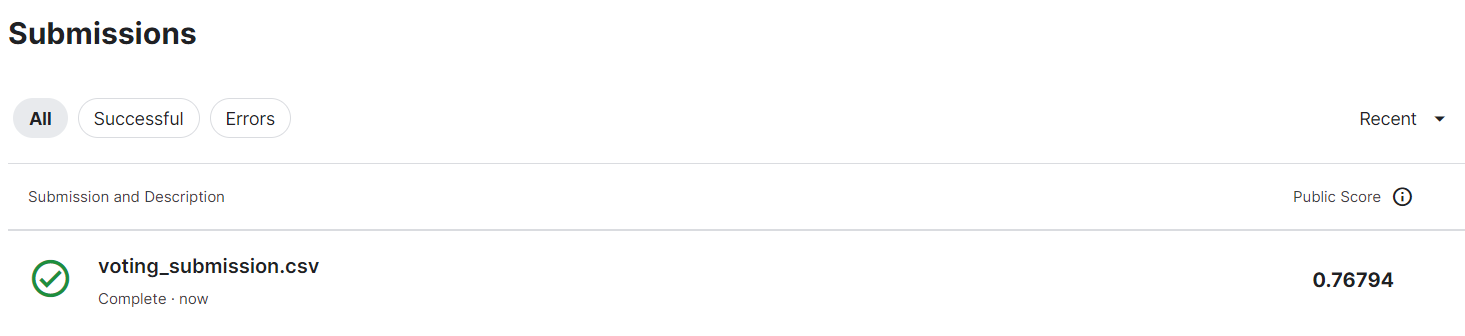

## Stack Classifiers

In [86]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier

voting = VotingClassifier([
    ('knn', KNeighborsClassifier()),
    ('svc', svm.SVC()),
    ('dtc', DecisionTreeClassifier()),
])

modelo = StackingClassifier([
    ('voting', voting),
    ('extrat', ExtraTreesClassifier()),
    ('ranfor', RandomForestClassifier())
], cv=3, passthrough=True)

pipetotal = Pipeline([
    ('preproc', preproc),
    ('modelo', modelo)
])

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.8888888888888888

In [87]:
#avaliação do modelo com validação cruzada
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([2.11280775, 2.09596872, 2.65578604, 3.2203002 , 2.76583672]),
  'score_time': array([0.05422711, 0.08199334, 0.23151875, 0.21269155, 0.05448961]),
  'test_score': array([0.7877095 , 0.82022472, 0.82022472, 0.81460674, 0.83707865])},
 0.8159688657334756)

In [88]:
#realiza a predição e cria arquivo para submissão ao kaggle
pipetotal.fit(X, y)
ypred = pipetotal.predict(test)

submission = pd.read_csv('/content/drive/MyDrive/datasets/gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('stacking_submission.csv', index=False)

Print da submissão do arquivo ao Kaggle

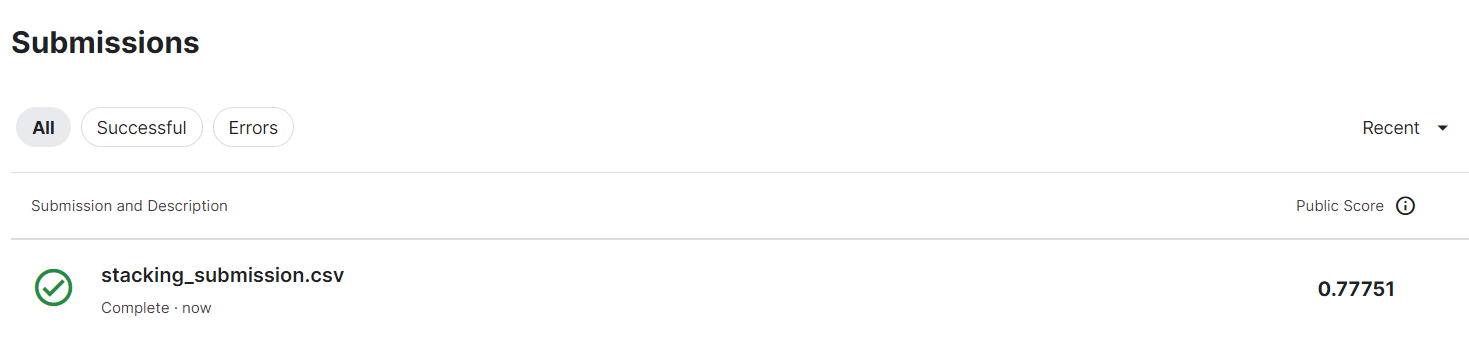